# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Functions

In [9]:
import math
import numpy as np

def parse_vrp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and filter empty lines
    lines = [line.strip() for line in lines if line.strip()]

    # Parse metadata
    metadata = {}
    i = 0
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:
            key, value = lines[i].split(':', 1)
            metadata[key.strip()] = value.strip().strip('"')
        i += 1

    # Parse node coordinates (1-based in file, but we'll make 0-based list)
    coords = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()
        if len(parts) == 3:
            node_id = int(parts[0]) - 1  # Make 0-based
            x, y = int(parts[1]), int(parts[2])
            # Insert at correct index in case not sequential (though they usually are)
            while len(coords) <= node_id:
                coords.append(None)
            coords[node_id] = (x, y)
        i += 1

    # Parse demands (0-based list)
    demands = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()
        if len(parts) == 2:
            node_id = int(parts[0]) - 1  # Make 0-based
            demand = int(parts[1])
            while len(demands) <= node_id:
                demands.append(None)
            demands[node_id] = demand
        i += 1

    # Parse depot(s) — usually just one, 1-based
    depots = []
    i += 1  # Skip section header
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])
        if depot == -1:
            break
        depots.append(depot - 1)  # Make 0-based
        i += 1

    # Compute distance matrix (Euclidean 2D)
    dimension = int(metadata.get('DIMENSION', len(coords)))
    dist_matrix = np.zeros((dimension, dimension))
    for a in range(dimension):
        for b in range(dimension):
            x1, y1 = coords[a]
            x2, y2 = coords[b]
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return {
        'metadata': metadata,
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of integers, 0-based
        'depots': depots,  # List of 0-based indices (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # Numpy array of floats
    }

# Example usage for your files
small_data = parse_vrp_file('data/small.vrp')
medium_data = parse_vrp_file('data/medium.vrp')
large_data = parse_vrp_file('data/large.vrp')

# Print some extracted info from large (based on the provided sample)
print(large_data['metadata'])
print("Depot index:", large_data['depots'][0])
print("Sample coords (first 5):", large_data['coords'][:5])
print("Sample demands (first 5):", large_data['demands'][:5])
print("Sample distance (node 0 to 1):", large_data['dist_matrix'][0][1])

{'NAME': 'X-n101-k25', 'COMMENT': 'Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)', 'TYPE': 'CVRP', 'DIMENSION': '101', 'EDGE_WEIGHT_TYPE': 'EUC_2D', 'CAPACITY': '206'}
Depot index: 0
Sample coords (first 5): [(365, 689), (146, 180), (792, 5), (658, 510), (461, 270)]
Sample demands (first 5): [0, 38, 51, 73, 70]
Sample distance (node 0 to 1): 554.1137067425782


## NSGA-II Implementation

In [10]:
import numpy as np
import random
import time

class NSGAII:
    def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
        self.data = data
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []
        
        # **OPTIMIZATION 1**: Pre-compute frequently accessed values
        self.dist_matrix = self.data['dist_matrix']
        self.capacity = int(self.data['metadata']['CAPACITY'])
        self.demands = self.data['demands']
        self.n_customers = len(self.data['coords']) - 1
        self.customer_range = list(range(1, self.n_customers + 1))

    def split_routes(self, customer_sequence):
        """**OPTIMIZATION 2**: Streamlined route splitting with pre-computed values"""
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = self.demands[customer]
            if load + demand > self.capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def calculate_route_distance(self, route):
        """**OPTIMIZATION 3**: Single route distance calculation for reuse"""
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_objectives_fast(self, individual):
        """**OPTIMIZATION 4**: Avoid recalculating if already computed"""
        if individual['objectives'] is not None:
            return
        
        routes = individual['routes']
        route_distances = [self.calculate_route_distance(route) for route in routes]
        total_dist = sum(route_distances)
        max_length = max(route_distances) if route_distances else 0.0
        individual['objectives'] = [total_dist, max_length]

    def generate_initial_population(self):
        """**OPTIMIZATION 5**: Reuse customer range list"""
        population = []
        for _ in range(self.pop_size):
            perm = self.customer_range[:]
            random.shuffle(perm)
            individual = {
                'customer_sequence': perm,
                'routes': self.split_routes(perm),
                'objectives': None,
                'rank': None,
                'crowding_distance': 0.0
            }
            population.append(individual)
        return population

    def evaluate_objectives(self, population):
        """**OPTIMIZATION 6**: Use fast evaluation method"""
        for individual in population:
            self.evaluate_objectives_fast(individual)

    def fast_non_dominated_sort(self, population):
        """**OPTIMIZATION 7**: Simplified dominance check for 2 objectives only"""
        n = len(population)
        objectives = [ind['objectives'] for ind in population]
        
        domination_count = [0] * n
        dominated_solutions = [[] for _ in range(n)]
        
        # **OPTIMIZATION 8**: Optimized for exactly 2 objectives
        for i in range(n):
            obj1_i, obj2_i = objectives[i]
            for j in range(i + 1, n):
                obj1_j, obj2_j = objectives[j]
                
                # Fast 2-objective dominance check
                if (obj1_i <= obj1_j and obj2_i <= obj2_j) and (obj1_i < obj1_j or obj2_i < obj2_j):
                    dominated_solutions[i].append(j)
                    domination_count[j] += 1
                elif (obj1_j <= obj1_i and obj2_j <= obj2_i) and (obj1_j < obj1_i or obj2_j < obj2_i):
                    dominated_solutions[j].append(i)
                    domination_count[i] += 1
        
        # Process fronts
        current_front = [i for i in range(n) if domination_count[i] == 0]
        rank = 1
        
        for i in current_front:
            population[i]['rank'] = rank
        
        while current_front:
            next_front = []
            for i in current_front:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        next_front.append(j)
            
            if next_front:
                rank += 1
                for i in next_front:
                    population[i]['rank'] = rank
            
            current_front = next_front

    def calculate_crowding_distance(self, population):
        """**OPTIMIZATION 9**: Streamlined crowding distance for 2 objectives"""
        for ind in population:
            ind['crowding_distance'] = 0.0
        
        rank_groups = {}
        for i, ind in enumerate(population):
            rank = ind['rank']
            if rank not in rank_groups:
                rank_groups[rank] = []
            rank_groups[rank].append(i)
        
        for indices in rank_groups.values():
            n_front = len(indices)
            if n_front <= 2:
                for i in indices:
                    population[i]['crowding_distance'] = float('inf')
                continue
            
            # **OPTIMIZATION 10**: Hardcoded for 2 objectives
            for obj_idx in range(2):
                indices.sort(key=lambda i: population[i]['objectives'][obj_idx])
                
                population[indices[0]]['crowding_distance'] = float('inf')
                population[indices[-1]]['crowding_distance'] = float('inf')
                
                obj_range = population[indices[-1]]['objectives'][obj_idx] - population[indices[0]]['objectives'][obj_idx]
                
                if obj_range > 0:
                    for j in range(1, n_front - 1):
                        i = indices[j]
                        if population[i]['crowding_distance'] != float('inf'):
                            prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                            next_obj = population[indices[j+1]]['objectives'][obj_idx]
                            population[i]['crowding_distance'] += (next_obj - prev_obj) / obj_range

    def tournament_selection(self, population, tournament_size=2):
        tournament = random.sample(population, tournament_size)
        return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

    def create_individual(self, customer_sequence):
        """**OPTIMIZATION 11**: Helper for cleaner individual creation"""
        return {
            'customer_sequence': customer_sequence,
            'routes': self.split_routes(customer_sequence),
            'objectives': None,
            'rank': None,
            'crowding_distance': 0.0
        }

    def pmx_crossover(self, parent1, parent2):
        """**OPTIMIZATION 12**: Simplified PMX crossover"""
        size = len(parent1['customer_sequence'])
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']

        if size < 2:
            return self.create_individual(p1[:])

        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        
        for i in range(start, end + 1):
            child[i] = p1[i]

        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        
        for i in range(size):
            if child[i] is None:
                gene = p2[i]
                while gene in mapping:
                    gene = mapping[gene]
                
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                
                child[i] = gene

        return self.create_individual(child)

    def swap_mutation(self, individual):
        """**OPTIMIZATION 13**: More efficient mutation"""
        seq = individual['customer_sequence'][:]
        
        # Only mutate if random check passes
        if random.random() < self.mutation_rate:
            for _ in range(max(1, int(len(seq) * self.mutation_rate * 0.5))):
                i, j = random.sample(range(len(seq)), 2)
                seq[i], seq[j] = seq[j], seq[i]
        
        return self.create_individual(seq)

    def run(self):
        """**OPTIMIZATION 14**: Removed all prints during evolution for major speedup"""
        self.population = self.generate_initial_population()
        self.evaluate_objectives(self.population)
        self.fast_non_dominated_sort(self.population)
        self.calculate_crowding_distance(self.population)

        for gen in range(1, self.generations + 1):
            offspring = []

            for _ in range(self.pop_size):
                parent1 = self.tournament_selection(self.population)
                parent2 = self.tournament_selection(self.population)

                if random.random() < self.crossover_rate:
                    child = self.pmx_crossover(parent1, parent2)
                else:
                    child = self.create_individual(parent1['customer_sequence'][:])

                child = self.swap_mutation(child)
                offspring.append(child)

            self.evaluate_objectives(offspring)
            combined = self.population + offspring
            self.fast_non_dominated_sort(combined)
            self.calculate_crowding_distance(combined)
            combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
            self.population = combined[:self.pop_size]

        return self.population

## SPEA2 Implementation

In [11]:
## TODO ADD ALGO

# Experiment

Running experiments sequentially (optimized for Jupyter)...

=== NSGAII | Param Set 1 (Conservative) ===
--- Instance: Small ---
  Run 10/20 completed. Progress: 5.6% (28.8s)
  Run 20/20 completed. Progress: 11.1% (57.5s)
--- Instance: Medium ---
  Run 10/20 completed. Progress: 16.7% (109.7s)
  Run 20/20 completed. Progress: 22.2% (161.8s)
--- Instance: Large ---
  Run 10/20 completed. Progress: 27.8% (247.6s)
  Run 20/20 completed. Progress: 33.3% (326.7s)

=== NSGAII | Param Set 2 (Balanced) ===
--- Instance: Small ---
  Run 10/20 completed. Progress: 38.9% (332.0s)
  Run 20/20 completed. Progress: 44.4% (337.3s)
--- Instance: Medium ---
  Run 10/20 completed. Progress: 50.0% (348.5s)
  Run 20/20 completed. Progress: 55.6% (359.4s)
--- Instance: Large ---
  Run 10/20 completed. Progress: 61.1% (378.5s)
  Run 20/20 completed. Progress: 66.7% (397.2s)

=== NSGAII | Param Set 3 (Aggressive) ===
--- Instance: Small ---
  Run 10/20 completed. Progress: 72.2% (398.4s)
  Run 20/20 complete

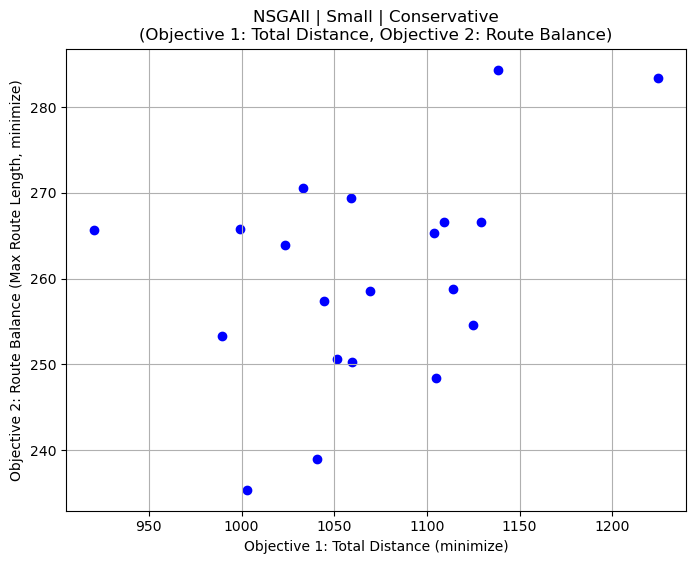

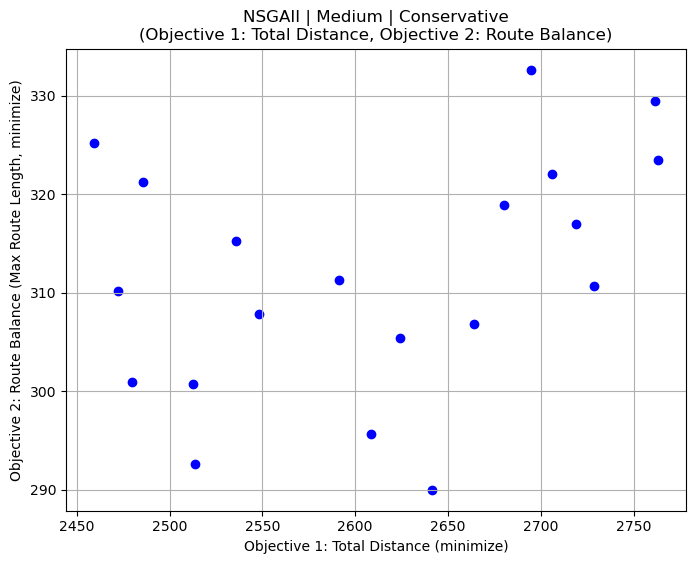

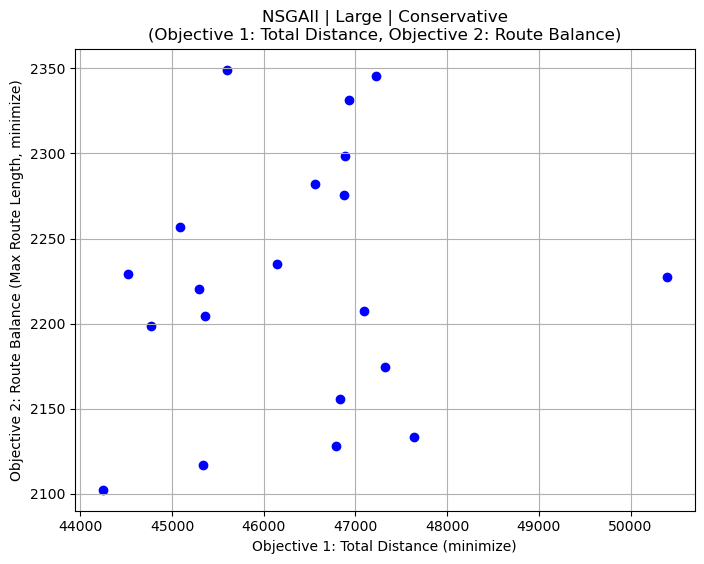

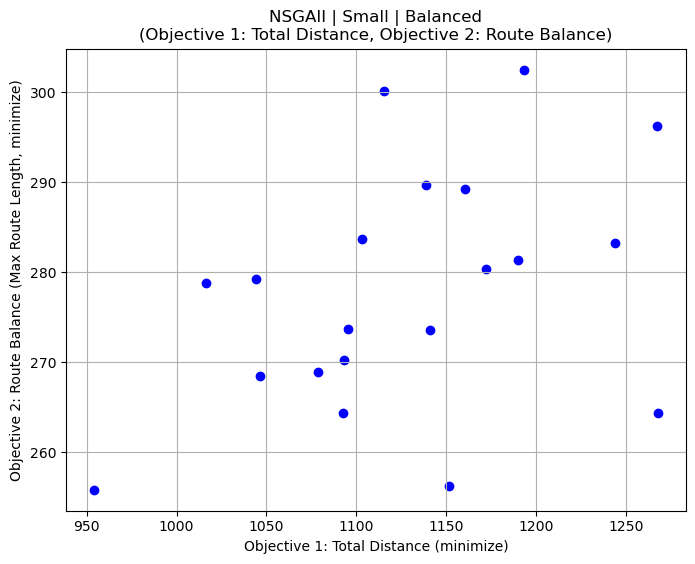

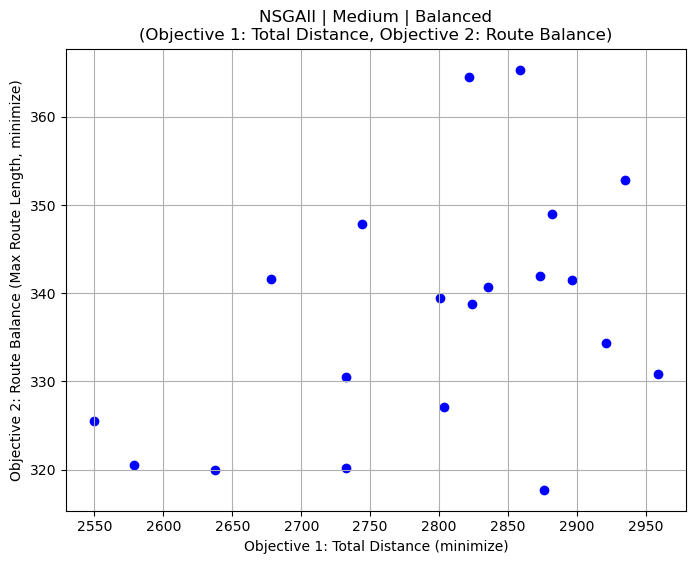

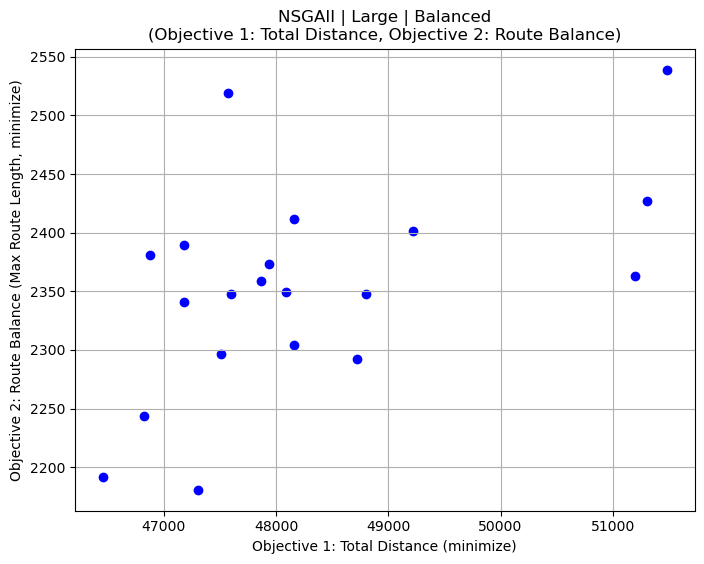

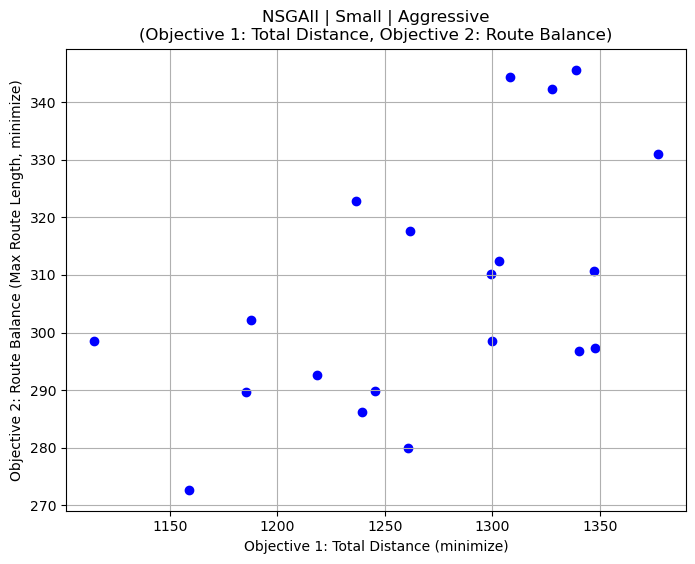

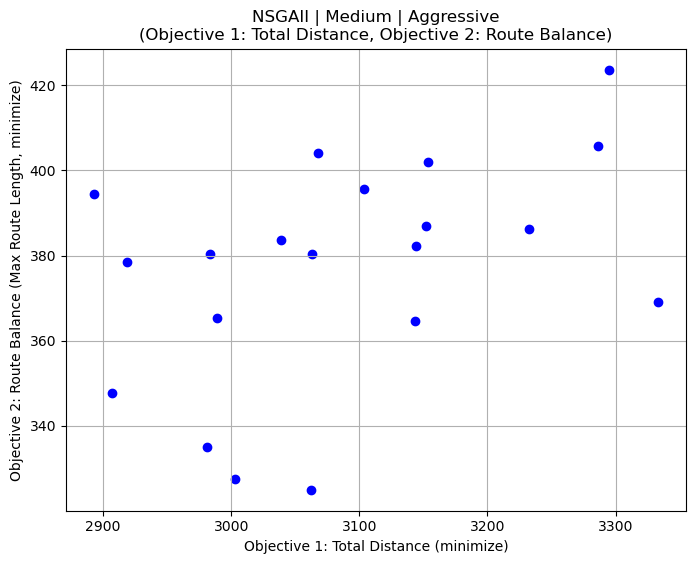

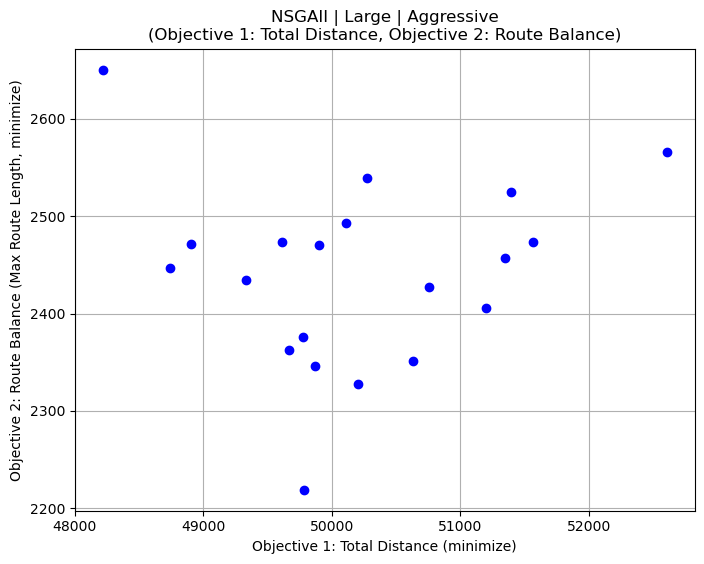

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Descriptive names for parameter sets
param_set_names = {
    1: "Conservative",
    2: "Balanced", 
    3: "Aggressive"
}

def run_full_experiment_sequential(moea_classes, instance_files, param_sets, num_runs=20):
    """Sequential experiment execution - works in Jupyter notebooks"""
    print("Running experiments sequentially (optimized for Jupyter)...")
    
    results = []
    total_experiments = len(moea_classes) * len(param_sets) * len(instance_files) * num_runs
    current_experiment = 0
    
    start_time = time.time()
    
    for algo_name, algo_class in moea_classes:
        for param_idx, params in enumerate(param_sets):
            print(f"\n=== {algo_name} | Param Set {param_idx+1} ({param_set_names[param_idx+1]}) ===")
            for inst_name, inst_file in instance_files:
                print(f"--- Instance: {inst_name} ---")
                for run in range(1, num_runs + 1):
                    current_experiment += 1
                    
                    # Set seeds for reproducibility
                    random.seed(run)
                    np.random.seed(run)
                    
                    # Load data and run algorithm
                    data = parse_vrp_file(inst_file)
                    moea = algo_class(
                        data=data,
                        pop_size=params['pop_size'],
                        generations=params['generations'],
                        crossover_rate=params['crossover_rate'],
                        mutation_rate=params['mutation_rate']
                    )
                    
                    run_start = time.time()
                    final_population = moea.run()
                    elapsed = time.time() - run_start
                    
                    # Extract results
                    pareto_front = [ind for ind in final_population if ind['rank'] == 1]
                    pareto_size = len(pareto_front)
                    best_total_distance = min(ind['objectives'][0] for ind in pareto_front)
                    best_max_route = min(ind['objectives'][1] for ind in pareto_front)
                    
                    results.append({
                        "algorithm": algo_name,
                        "param_set": param_idx + 1,
                        "instance": inst_name,
                        "run": run,
                        "pareto_size": pareto_size,
                        "best_total_distance": best_total_distance,
                        "best_max_route": best_max_route,
                        "elapsed_time": elapsed,
                        "evaluations": params['pop_size'] * params['generations']
                    })
                    
                    # Progress update every 10 runs
                    if run % 10 == 0 or run == num_runs:
                        total_elapsed = time.time() - start_time
                        progress = (current_experiment / total_experiments) * 100
                        print(f"  Run {run}/{num_runs} completed. Progress: {progress:.1f}% ({total_elapsed:.1f}s)")
    
    total_time = time.time() - start_time
    print(f"\nAll experiments completed in {total_time:.1f} seconds")
    
    # Convert to DataFrame and save
    df = pd.DataFrame(results)
    print_dense_summary_table(df)
    df.to_csv('nsga2_results.csv', index=False)
    return results

def plot_final_pareto(results, instance=None, param_set=None, algo=None):
    """Unchanged plotting function"""
    filtered = results
    title_parts = []
    if algo:
        filtered = [r for r in filtered if r['algorithm'] == algo]
        title_parts.append(algo)
    if instance:
        filtered = [r for r in filtered if r['instance'] == instance]
        title_parts.append(instance)
    if param_set:
        filtered = [r for r in filtered if r['param_set'] == param_set]
        param_name = param_set_names.get(param_set, f"ParamSet {param_set}")
        title_parts.append(param_name)
    title = " | ".join(title_parts) if title_parts else "All Results"
    title += "\n(Objective 1: Total Distance, Objective 2: Route Balance)"
    obj1 = [r['best_total_distance'] for r in filtered]
    obj2 = [r['best_max_route'] for r in filtered]
    plt.figure(figsize=(8,6))
    plt.scatter(obj1, obj2, c='blue')
    plt.xlabel("Objective 1: Total Distance (minimize)")
    plt.ylabel("Objective 2: Route Balance (Max Route Length, minimize)")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_dense_summary_table(df):
    """Unchanged summary table function"""
    print("\n=== FITNESS SCORES SUMMARY TABLE ===")
    groups = df.groupby(['instance', 'param_set'])
    header = ("Instance | ParamSet      | Best Dist | Avg Dist | Worst Dist | Std Dist | "
              "Best MaxRoute | Avg MaxRoute | Worst MaxRoute | Std MaxRoute")
    print(header)
    print("-" * len(header))
    for (instance, param_set), group in groups:
        best_dist = group['best_total_distance'].min()
        avg_dist = group['best_total_distance'].mean()
        worst_dist = group['best_total_distance'].max()
        std_dist = group['best_total_distance'].std()
        best_max = group['best_max_route'].min()
        avg_max = group['best_max_route'].mean()
        worst_max = group['best_max_route'].max()
        std_max = group['best_max_route'].std()
        param_name = param_set_names.get(param_set, str(param_set))
        print(f"{instance:7} | {param_name:13} | "
              f"{best_dist:9.2f} | {avg_dist:8.2f} | {worst_dist:10.2f} | {std_dist:8.2f} | "
              f"{best_max:13.2f} | {avg_max:12.2f} | {worst_max:13.2f} | {std_max:10.2f}")

# Run experiments sequentially (Jupyter-compatible)
moea_classes = [
    ("NSGAII", NSGAII),
]
instance_files = [
    ("Small", "data/Small.vrp"),
    ("Medium", "data/Medium.vrp"),
    ("Large", "data/Large.vrp"),
]
param_sets = [
    {"pop_size": 100, "generations": 500, "crossover_rate": 0.7, "mutation_rate": 0.2},
    {"pop_size": 50, "generations": 250, "crossover_rate": 0.7, "mutation_rate": 0.2},
    {"pop_size": 30, "generations": 100, "crossover_rate": 0.7, "mutation_rate": 0.2},
]

# Run experiments
results = run_full_experiment_sequential(moea_classes, instance_files, param_sets, num_runs=20)

# Plot results
for param_set in [1, 2, 3]:
    for inst_name in ["Small", "Medium", "Large"]:
        plot_final_pareto(results, instance=inst_name, param_set=param_set, algo="NSGAII")